# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer  

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import pipeline

plt.style.use('ggplot')

# Data Preprcoessing

In [2]:
df=pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df['Text'].sample(2)

498716    Mexico does not have the same standards for<br...
400133    Ingredients are listed in order from largest a...
Name: Text, dtype: object

In [4]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

Text(0.5, 0, 'Star Rating')

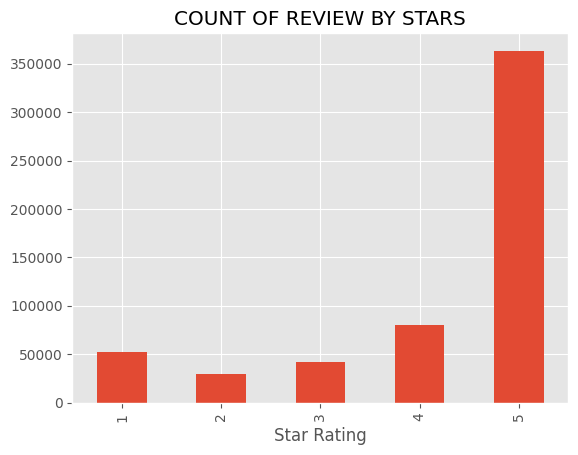

In [5]:
ax1=df['Score'].value_counts().sort_index().plot(kind='bar',title="COUNT OF REVIEW BY STARS")
ax1.set_xlabel('Star Rating')

In [6]:
#PERFORMING UNDERSAMPLING
from imblearn.under_sampling import RandomUnderSampler
rs=RandomUnderSampler(sampling_strategy={1:10000,2:10000,3:10000,4:10000,5:10000})
x_res,y_res=rs.fit_resample(df,df['Score'])

In [7]:
new_df=x_res
new_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
526015,526016,B003HD26NG,A2SYW8B9U2K845,chefjill,0,11,1,1304208000,crushedcookies,I thought this was a cook book? The cookies ar...
460583,460584,B004JXDCC2,AJ6D41YMLMNRR,R. Johnson,10,12,1,1299801600,Agree with Joe Compute,I agree with Joe....this is ridiculous. Not l...
479542,479543,B00514EUT2,A2RLJDBNDC2XHW,"YY ""YY""",0,1,1,1347235200,Over priced!,Found the same product in Target and it only c...
27670,27671,B000K8ESBE,A3H4RR9A4OSA5W,GARRYS FREETELEVISION,0,0,1,1304726400,AWFUL,Do not waste your money on this. I waited anxi...
441908,441909,B004E4HUMY,A2503LT8PZIHAD,"Scary Gertrude, the Bad Sheriff for Life ""Li...",2,3,1,1328400000,No tea leaves were harmed in the making of thi...,At first this didn't taste like anything. By ...


In [8]:
#PERFORMING UNDERSAMPLING
from imblearn.under_sampling import RandomUnderSampler
rs=RandomUnderSampler(sampling_strategy={1:10000,2:10000,3:10000,4:10000,5:10000})
x_res,y_res=rs.fit_resample(df,df['Score'])

In [9]:
#AFTER UNDERSAMPLING
new_df['Score'].value_counts()

Score
1    10000
2    10000
3    10000
4    10000
5    10000
Name: count, dtype: int64

Text(0.5, 0, 'Star Rating')

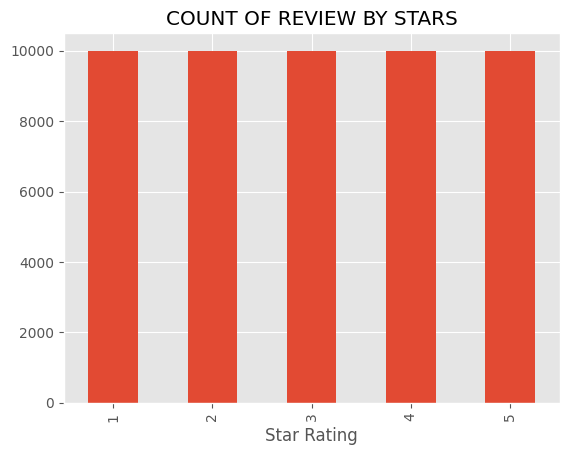

In [10]:
ax2=new_df['Score'].value_counts().sort_index().plot(kind='bar',title="COUNT OF REVIEW BY STARS")
ax2.set_xlabel('Star Rating')

# Classifying Reviews using VADER Model

In [11]:
sia=SentimentIntensityAnalyzer()

In [12]:
sia.polarity_scores(" It's as good as expected ")

{'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}

In [13]:
sia.polarity_scores("It's ridiculous")

{'neg': 0.714, 'neu': 0.286, 'pos': 0.0, 'compound': -0.3612}

In [14]:
sia.polarity_scores("Most of the time it is good,but rarely it fails.")

{'neg': 0.0, 'neu': 0.794, 'pos': 0.206, 'compound': 0.3252}

In [15]:
res={}
for i ,row in tqdm(new_df.iterrows(),total=len(new_df)):
    text=row['Text']
    myid=row['Id']
    res[myid]=sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [16]:
vaders=pd.DataFrame(res).T
vaders.head()

,neg,neu,pos,compound
526016,0.256,0.744,0.000,-0.6711
460584,0.116,0.787,0.097,-0.0026
479543,0.000,1.000,0.000,0.0000
27671,0.068,0.882,0.050,-0.3056
441909,0.103,0.830,0.067,-0.6083


In [17]:
vaders=vaders.rename(columns={'neg':"vaders_negative",'neu':"vaders_neutral",'pos':"vaders_positive",'compound':"vaders_compound"})

In [18]:
vaders.head()

,vaders_negative,vaders_neutral,vaders_positive,vaders_compound
526016,0.256,0.744,0.000,-0.6711
460584,0.116,0.787,0.097,-0.0026
479543,0.000,1.000,0.000,0.0000
27671,0.068,0.882,0.050,-0.3056
441909,0.103,0.830,0.067,-0.6083


In [19]:
vaders=vaders.reset_index()
vaders.head()

,index,vaders_negative,vaders_neutral,vaders_positive,vaders_compound
0,526016,0.256,0.744,0.000,-0.6711
1,460584,0.116,0.787,0.097,-0.0026
2,479543,0.000,1.000,0.000,0.0000
3,27671,0.068,0.882,0.050,-0.3056
4,441909,0.103,0.830,0.067,-0.6083


In [20]:
vaders=vaders.rename(columns={'index':'Id'})

In [21]:
vaders=vaders.merge(new_df,how='left')
vaders.head()

,Id,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,526016,0.256,0.744,0.000,-0.6711,B003HD26NG,A2SYW8B9U2K845,chefjill,0,11,1,1304208000,crushedcookies,I thought this was a cook book? The cookies ar...
1,460584,0.116,0.787,0.097,-0.0026,B004JXDCC2,AJ6D41YMLMNRR,R. Johnson,10,12,1,1299801600,Agree with Joe Compute,I agree with Joe....this is ridiculous. Not l...
2,479543,0.000,1.000,0.000,0.0000,B00514EUT2,A2RLJDBNDC2XHW,"YY ""YY""",0,1,1,1347235200,Over priced!,Found the same product in Target and it only c...
3,27671,0.068,0.882,0.050,-0.3056,B000K8ESBE,A3H4RR9A4OSA5W,GARRYS FREETELEVISION,0,0,1,1304726400,AWFUL,Do not waste your money on this. I waited anxi...
4,441909,0.103,0.830,0.067,-0.6083,B004E4HUMY,A2503LT8PZIHAD,"Scary Gertrude, the Bad Sheriff for Life ""Li...",2,3,1,1328400000,No tea leaves were harmed in the making of thi...,At first this didn't taste like anything. By ...


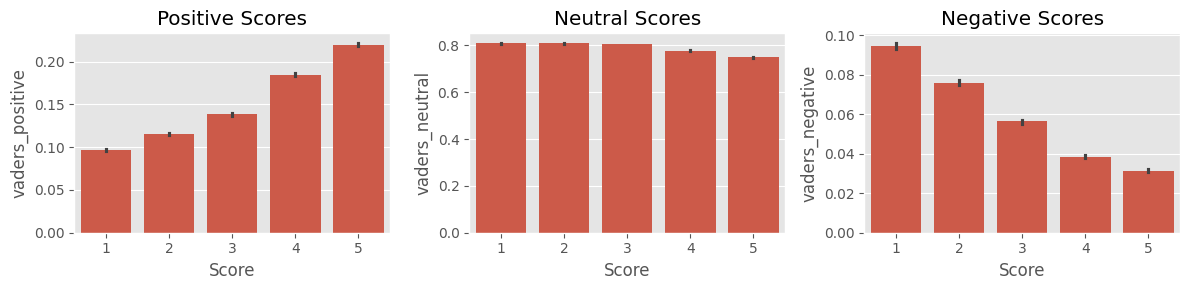

In [22]:
#Visualizing The Change In Scores With Respect To Star Ratings
fig,ax3=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=vaders,x='Score',y='vaders_positive',ax=ax3[0])
sns.barplot(data=vaders,x='Score',y='vaders_neutral',ax=ax3[1])
sns.barplot(data=vaders,x='Score',y='vaders_negative',ax=ax3[2])
ax3[0].set_title("Positive Scores")
ax3[1].set_title("Neutral Scores")
ax3[2].set_title("Negative Scores")
plt.tight_layout()

In [23]:
#Setting Threshold values
vpred=[]
for i,row in tqdm(vaders.iterrows(),total=len(vaders)):
    comp_score=row['vaders_compound']
    if(comp_score>0.4):
        vpred.append("Positve")
    elif(comp_score<0):
        vpred.append("Negative")
    else:
        vpred.append("Neutral")

  0%|          | 0/50000 [00:00<?, ?it/s]

In [24]:
vpred=pd.DataFrame(vpred)

In [25]:
vaders_fin=pd.concat([vaders,vpred],axis=1)

In [26]:
vaders_fin=vaders_fin.rename(columns={0:'Vaders Prediction'})
vaders_fin.head()

,Id,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Vaders Prediction
0,526016,0.256,0.744,0.000,-0.6711,B003HD26NG,A2SYW8B9U2K845,chefjill,0,11,1,1304208000,crushedcookies,I thought this was a cook book? The cookies ar...,Negative
1,460584,0.116,0.787,0.097,-0.0026,B004JXDCC2,AJ6D41YMLMNRR,R. Johnson,10,12,1,1299801600,Agree with Joe Compute,I agree with Joe....this is ridiculous. Not l...,Negative
2,479543,0.000,1.000,0.000,0.0000,B00514EUT2,A2RLJDBNDC2XHW,"YY ""YY""",0,1,1,1347235200,Over priced!,Found the same product in Target and it only c...,Neutral
3,27671,0.068,0.882,0.050,-0.3056,B000K8ESBE,A3H4RR9A4OSA5W,GARRYS FREETELEVISION,0,0,1,1304726400,AWFUL,Do not waste your money on this. I waited anxi...,Negative
4,441909,0.103,0.830,0.067,-0.6083,B004E4HUMY,A2503LT8PZIHAD,"Scary Gertrude, the Bad Sheriff for Life ""Li...",2,3,1,1328400000,No tea leaves were harmed in the making of thi...,At first this didn't taste like anything. By ...,Negative


# Classifying Reviews using ROBERTA Pretrained Model

In [27]:
MODEL=f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)

In [28]:
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

In [29]:
def roberta_polarity_scores(text):
  encoded_txt=tokenizer(text,return_tensors='pt')
  output=model(**encoded_txt)
  scores=output[0][0].detach().numpy()
  scores=softmax(scores)
  scores_dict={'roberta_negative':scores[0],'roberta_neutral':scores[1],'roberta_positive':scores[2]}
  return scores_dict

In [30]:
result={}
for i ,row in tqdm(new_df.iterrows(),total=len(new_df)):
  try:
    text=row['Text']
    myid=row['Id']
    result[myid]=roberta_polarity_scores(text)
  except Exception:
        pass

  0%|          | 0/50000 [00:00<?, ?it/s]

In [31]:
roberta=pd.DataFrame(result).T
roberta=roberta.reset_index().rename(columns={'index':'Id'})

In [32]:
roberta

,Id,roberta_negative,roberta_neutral,roberta_positive
0,526016,0.971950,0.025447,0.002603
1,460584,0.793972,0.182092,0.023936
2,479543,0.012973,0.410004,0.577023
3,27671,0.564036,0.328049,0.107915
4,441909,0.612264,0.324739,0.062997
...,...,...,...,...
49415,487462,0.002331,0.012470,0.985199
49416,170036,0.008988,0.087353,0.903659
49417,516989,0.001725,0.029677,0.968598
49418,556846,0.001329,0.014937,0.983733


In [33]:
roberta=roberta.merge(vaders_fin,how='left')

In [34]:
roberta_polarity_scores("It's good as expected")

{'roberta_negative': 0.004768506,
 'roberta_neutral': 0.03425236,
 'roberta_positive': 0.96097916}

In [35]:
roberta_polarity_scores("It's ridiculous")

{'roberta_negative': 0.84095603,
 'roberta_neutral': 0.13255285,
 'roberta_positive': 0.026491087}

In [36]:
roberta_polarity_scores("Most of the time it is good,but rarely it fails.")

{'roberta_negative': 0.08156551,
 'roberta_neutral': 0.31656712,
 'roberta_positive': 0.6018673}

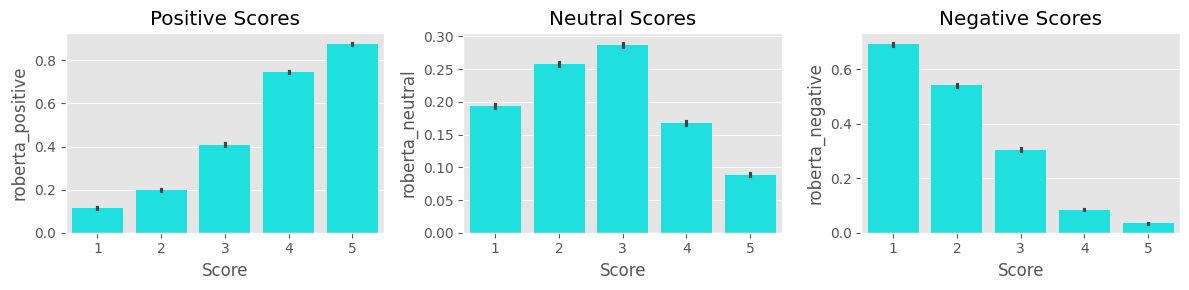

In [37]:
#Visualizing The Change In Scores With Respect To Star Ratings
fig,ax4=plt.subplots(1,3,figsize=(12,3))
sns.barplot(data=roberta,x='Score',y='roberta_positive',ax=ax4[0],color='cyan')
sns.barplot(data=roberta,x='Score',y='roberta_neutral',ax=ax4[1],color='cyan')
sns.barplot(data=roberta,x='Score',y='roberta_negative',ax=ax4[2],color='cyan')
ax4[0].set_title("Positive Scores")
ax4[1].set_title("Neutral Scores")
ax4[2].set_title("Negative Scores")
plt.tight_layout()

In [38]:
#Setting Threshold Values
rpred=[]
for i,row in tqdm(roberta.iterrows(),total=len(roberta)):
    compute_scores=[row['roberta_negative'],row['roberta_neutral'],row['roberta_positive']]
    if(max(compute_scores)==compute_scores[0]):
        rpred.append("Negative")
    elif(max(compute_scores)==compute_scores[1]):
        rpred.append("Neutral")
    else:
        rpred.append("Positive")

  0%|          | 0/49420 [00:00<?, ?it/s]

In [39]:
rpred=pd.DataFrame(rpred)

In [40]:
roberta_fin=pd.concat([roberta,rpred],axis=1)
roberta_fin=roberta_fin.rename(columns={0:"Roberta Prediction"})
roberta_fin

,Id,roberta_negative,roberta_neutral,roberta_positive,vaders_negative,vaders_neutral,vaders_positive,vaders_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Vaders Prediction,Roberta Prediction
0,526016,0.971950,0.025447,0.002603,0.256,0.744,0.000,-0.6711,B003HD26NG,A2SYW8B9U2K845,chefjill,0,11,1,1304208000,crushedcookies,I thought this was a cook book? The cookies ar...,Negative,Negative
1,460584,0.793972,0.182092,0.023936,0.116,0.787,0.097,-0.0026,B004JXDCC2,AJ6D41YMLMNRR,R. Johnson,10,12,1,1299801600,Agree with Joe Compute,I agree with Joe....this is ridiculous. Not l...,Negative,Negative
2,479543,0.012973,0.410004,0.577023,0.000,1.000,0.000,0.0000,B00514EUT2,A2RLJDBNDC2XHW,"YY ""YY""",0,1,1,1347235200,Over priced!,Found the same product in Target and it only c...,Neutral,Positive
3,27671,0.564036,0.328049,0.107915,0.068,0.882,0.050,-0.3056,B000K8ESBE,A3H4RR9A4OSA5W,GARRYS FREETELEVISION,0,0,1,1304726400,AWFUL,Do not waste your money on this. I waited anxi...,Negative,Negative
4,441909,0.612264,0.324739,0.062997,0.103,0.830,0.067,-0.6083,B004E4HUMY,A2503LT8PZIHAD,"Scary Gertrude, the Bad Sheriff for Life ""Li...",2,3,1,1328400000,No tea leaves were harmed in the making of thi...,At first this didn't taste like anything. By ...,Negative,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49415,487462,0.002331,0.012470,0.985199,0.000,0.773,0.227,0.9434,B002G0CA6O,AHSQEALV8VY9T,"mizpahmunchkin ""mizpah""",0,0,5,1251158400,Yummy!!!,It took a while for me to find this flavor in ...,Positve,Positive
49416,170036,0.008988,0.087353,0.903659,0.051,0.876,0.073,0.2177,B006285RPC,A9VVNJINSK96V,Khaizoom,0,0,5,1330387200,Been buying these since 1980z.,Good quality chocolate with tasty biscuit. A l...,Neutral,Positive
49417,516989,0.001725,0.029677,0.968598,0.000,0.712,0.288,0.8655,B000G1PAC6,A3VDTXIOAB0PM3,mawolflady12,0,0,5,1333497600,Great Tea!,Received this tea very quickly. A mild tea wi...,Positve,Positive
49418,556846,0.001329,0.014937,0.983733,0.027,0.816,0.157,0.8062,B000H0ZJHW,A3FV8UWW0KVI82,W. Sprague,0,0,5,1300492800,THE BEST,I always have one or two bags of these treats ...,Positve,Positive


# Analayzing the Classifications of VADER and ROBERTA Pretrained Models

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
comp_df=roberta_fin[['Id','Summary','Score','Text','Vaders Prediction','Roberta Prediction']]
comp_df

,Id,Summary,Score,Text,Vaders Prediction,Roberta Prediction
0,526016,crushedcookies,1,"I thought this was a cook book? The cookies arrived all smashed and broken, uneatable. Not a good purchase at all.",Negative,Negative
1,460584,Agree with Joe Compute,1,I agree with Joe....this is ridiculous. Not like the other good buys on Amazon. You can buy it like he said for around $6.00 or less on sale so why would anyone pay this much on here. I don't drink it but felt a comment was needed here about the price.,Negative,Negative
2,479543,Over priced!,1,Found the same product in Target and it only cost a bit more than a quarter of the price listing here.,Neutral,Positive
3,27671,AWFUL,1,"Do not waste your money on this. I waited anxiously for the mail to deliver. Made a fresh 12 oz cup of coffee, dropped in two tablets. Nothing. I dropped in two more. Changed the flavor of the black coffee, but not for the better. I had wanted this so I didn't have to use cream for flavor with all the calories. Not even a hint of CHOCOLATE flavor.",Negative,Negative
4,441909,No tea leaves were harmed in the making of this product,1,"At first this didn't taste like anything. By time I added enough Mio to taste something, I was then disgusted by the flavor. I like tea, truly I do. This is not tea. But I've found a few ways to describe this flavor:<br /><br />Sucking on brown saccharine?<br /><br />Chewing on stale aspirin?<br /><br />Someone dropped a cigarette butt in my water?<br /><br />Sweaty gym socks were wrung out in my glass?<br /><br />Someone left used motor oil on the bottom of my glass?<br /><br />This drink is a great idea but a terrible rendering of such. My teenager wanted to try it and I'm tempted to do a science experiment on him. We call him Big Foot and I'm wondering if it would stop the growth of said feet. I don't want him to stop growing taller (6'2"" now) so I wonder if I sprinkle it directly on his feet, if that would work? I'll get back to you.<br /><br />I keep trying to figure out how people like this. I've finally figured it out and I have a message for them: WATER is not spelled V.O.D.K.A",Negative,Negative
...,...,...,...,...,...,...
49415,487462,Yummy!!!,5,"It took a while for me to find this flavor in my local stores. I had heard Zevia had come out with this new flavor and I certainly wasn't disappointed, it is delicious! I like them all but regularly drink the cola flavor but Black Cherry is right up there with 'favorite'. I always liked black cherries so this was wonderful addition to the rest of the Zevia flavors.",Positve,Positive
49416,170036,Been buying these since 1980z.,5,Good quality chocolate with tasty biscuit. A lot of chocolate products are filled with sugar and what not. You can easily eat a cpl of these without the sugary flavor in your mouth. Been buying these since I was a kid.,Neutral,Positive
49417,516989,Great Tea!,5,Received this tea very quickly. A mild tea with a great taste. Will re-order this product from this supplier. Wish I had known about Wu Long tea's health benefits sooner!,Positve,Positive
49418,556846,THE BEST,5,"I always have one or two bags of these treats in my cupboard, they are perfect for training. If you have a small dog you can cut them into smaller pieces so you can ""jackpot"" the dog. My dog especially loves the peanut butter flavor but I buy all three. I highly recommend these!",Positve,Positive


In [43]:
comp_df['Vaders Prediction'].value_counts()

Vaders Prediction
Positve     32705
Negative    10677
Neutral      6038
Name: count, dtype: int64

In [44]:
comp_df['Roberta Prediction'].value_counts()

Roberta Prediction
Positive    24910
Negative    18371
Neutral      6139
Name: count, dtype: int64

In [45]:
inacc=[]
for i ,rows in tqdm(comp_df.iterrows(),total=len(comp_df)):
    vad=rows['Vaders Prediction']
    rob=rows['Roberta Prediction']
    star=rows['Score']
    if(vad!=rob):
        inacc.append([rows['Id'],star,vad,rob])

  0%|          | 0/49420 [00:00<?, ?it/s]

In [46]:
inacc[16]

[312490, 1, 'Positve', 'Neutral']

In [47]:
comp_df[comp_df['Id']==381722]['Text']  #THIS IS CLEARLY A NEGATIVE COMMENT AS STATED BY ROBERTA MODEL

Series([], Name: Text, dtype: object)

In [48]:
inacc[26]

[4007, 1, 'Positve', 'Negative']

In [49]:
comp_df[comp_df['Id']==146672]['Text']  #THIS IS CLEARLY A NEGATIVE STATEMENT [WITH SOME SARCASM!!] AS PREDICTED BY ROBERTA MODEL

89    I wanted the company to fix my problem, but they decided to instead cancel my order. It's cute, but I wouldn't order anything from them again.
Name: Text, dtype: object

In [50]:
inacc[39]

[417984, 1, 'Positve', 'Negative']

In [51]:
comp_df[comp_df['Id']==534414]['Text']  #THIS IS CLEARLY A NEGATIVE STATEMENT AS PREDICTED BY ROBERTA MODEL

6136    The regular version of this Chunky New England Clam Chowder has been a big favorite of mine for over 30 years. But now that I am on a low sodium diet, I have to look for substitutes.<br /><br />When I tried the Healthy Request version of Chunky Chicken Noodle, it tasted identical to the regular version. So I assumed that this Healthy Request version of New Englan Clam Chowder would also be as good as its regular version, but it isn't. It tastes awful. It's so bad that I can't possibly eat it. So I wasted my money by ordering a case.<br /><br />Now that I have learned my lesson, the hard way. Before I will order a case of any food product from Amazon. I first try it out by buying a single can from a local grocery store. If it isn't available to try locally. Then I simply won't order a case from Amazon.
Name: Text, dtype: object

In [52]:
# SO IT IS EVIDENT THAT ROBERTA PRETRAINED MODEL PERFORMS BETTER THAN VADER MODEL IN CASES OF COMPLEX RELATIONSHIPS BETWEEN WORDS

# Sentiment Analysis using ROBERTA PRETRAINED Model

In [53]:
def trying(example):
    cal=roberta_polarity_scores(example)
    s1,s2,s3=cal.get("roberta_negative"),cal.get("roberta_neutral"),cal.get("roberta_positive")
    if(max(s1,s2,s3)==s1):
       print("THE STATEMENT IS NEGATIVE")
    elif(max(s1,s2,s3)==s2):
       print("THE STATEMENT IS NEUTRAL")
    else:
        print("THE STATEMENT IS POSITIVE")

In [54]:
#TRY ANY STATEMENT HERE
trying("HE GOT SUCH LOW MARKS HOW CAN I BE HAPPY ABOUT IT")

THE STATEMENT IS NEGATIVE
